In [88]:
casename = "ConservationCheck-2dFlag";

### Include Dyn3d and config files

In [89]:
using Pkg
Pkg.activate("../..")

using Revise
using Dyn3d
using Interact, Reactive
using Plots
pyplot()

Plots.PyPlotBackend()

In [90]:
# problem dimension
ndim = 2
# numerical params
tf = 8
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 4
# config_body = ConfigBody(nbody)
config_body = ConfigBody(nbody, 4,
    [0. 0.; 1. 0.; 1. 1.0/nbody; 0. 1.0/nbody], 5)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody
stiff = 0.05
damp = 0.002
config_joints = Vector{ConfigJoint}(undef,njoint)
gap = 0.0

dof = Dof(3, "passive", stiff, damp, Motions())

config_joints[1] = ConfigJoint(njoint, "revolute",
    [0.,0.,-π/2+0.1*π,1.5,3.7,0.], zeros(Float64,6), 0, [dof], [0.0])

for i = 2:njoint
    config_joints[i] = ConfigJoint(njoint, "revolute", [0., 0., 0.0, 1.0/njoint+gap, 0., 0.],
        [0., 0., 0., -gap, 0., 0.], i-1, [dof], [0.0])
end

### Build joint-body chain

In [91]:
bodys, joints, system = BuildChain(config_bodys, config_joints,
                                   config_system)
bd = BodyDyn(bodys, joints, system)

This is a 4 body-joint system, system is fixed in space

### Initialize system state

In [92]:
# init system
bd, soln = InitSystem!(bd)

# init soln structure
solns = (Soln)[]
push!(solns, soln)

# init VertsHistory struct
vs = []
push!(vs, VertsHistory(system.nbody, bd.bs));

### Set up HERKBody object

In [93]:
herk = HERKBody(system.num_params,HERKFuncM, HERKFuncGT, HERKFuncG,
                (HERKFuncf,HERKFuncgti), (UpdatePosition!,UpdateVelocity!),
                _conservationcheck=true)

Order-3 HERK time-marching function like object for Dyn3d


### Time Marching

#### Note that sometimes the solver can break due to singular matrix. Change between fixed step or not to solve the problem

In [94]:
λhist = []
bdhist = []
thist = [];

In [95]:
idx = 0
@time begin
while soln.t < tf
    # advance one step
    global soln, bd, dict = herk(soln, bd, _isfixedstep=true)

    # record soln and verts_i info
    push!(solns, soln)
    push!(vs, VertsHistory(system.nbody, bd.bs))
    push!(thist,deepcopy(soln.t)) 
    push!(λhist,deepcopy(soln.λ))
    push!(bdhist,deepcopy(bd))
        
    # print progress
    global idx += 1
    if mod(idx,500) == 1
        println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4))")
    end
end
println("itr = $(idx), t = $(round(soln.t,digits=2)), dt = $(round(soln.dt,digits=4)) \n")
end

itr = 1, t = 0.0, dt = 0.001
itr = 501, t = 0.5, dt = 0.001
itr = 1001, t = 1.0, dt = 0.001
itr = 1501, t = 1.5, dt = 0.001
itr = 2001, t = 2.0, dt = 0.001
itr = 2501, t = 2.5, dt = 0.001
itr = 3001, t = 3.0, dt = 0.001
itr = 3501, t = 3.5, dt = 0.001
itr = 4001, t = 4.0, dt = 0.001
itr = 4501, t = 4.5, dt = 0.001
itr = 5001, t = 5.0, dt = 0.001
itr = 5501, t = 5.5, dt = 0.001
itr = 6001, t = 6.0, dt = 0.001
itr = 6501, t = 6.5, dt = 0.001
itr = 7001, t = 7.0, dt = 0.001
itr = 7501, t = 7.5, dt = 0.001
itr = 8000, t = 8.0, dt = 0.001 

 13.553600 seconds (19.30 M allocations: 4.368 GiB, 28.82% gc time)


## Momentum Conservation

#### In this example, joints have non-zero stiffness and damping. Gravity play a role as well. The body-joint chain is pinned at the beginning of the first body, so Lagrangian multiplier supports non-zero external force, but provides zero energy loss.

In [96]:
n = length(solns)-1
t = [solns[i].t for i=3:n+1]

# y_n+1 = y_n + RK(y'_n)
xmkin = [dict["mkin"][i][1].-dict["mkin"][i-1][1] for i=2:n]
xmlag = [dict["mlag"][i][1] for i=2:n]
xmgra = [dict["mgra"][i][1] for i=2:n]
xmsum = xmkin + xmlag + xmgra

ymkin = [dict["mkin"][i][2].-dict["mkin"][i-1][2] for i=2:n]
ymlag = [dict["mlag"][i][2] for i=2:n]
ymgra = [dict["mgra"][i][2] for i=2:n]
ymsum = ymkin + ymlag + ymgra;

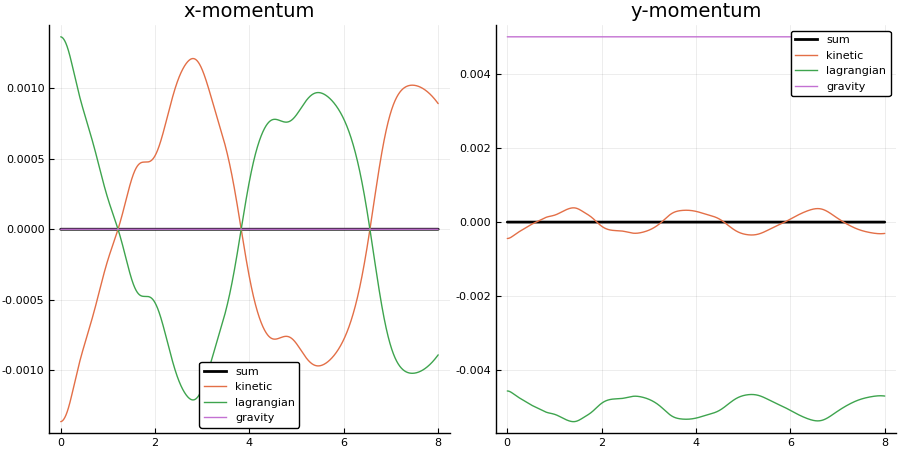

In [97]:
p1 = plot(t,xmsum,title="x-momentum",label="sum",linewidth=2,color="black")
plot!(p1,t,xmkin,label="kinetic")
plot!(p1,t,xmlag,label="lagrangian")
plot!(p1,t,xmgra,label="gravity")

p2 = plot(t,ymsum,title="y-momentum",label="sum",linewidth=2,color="black")
plot!(p2,t,ymkin,label="kinetic")
plot!(p2,t,ymlag,label="lagrangian")
plot!(p2,t,ymgra,label="gravity")

plot(p1,p2,size=(900,450))

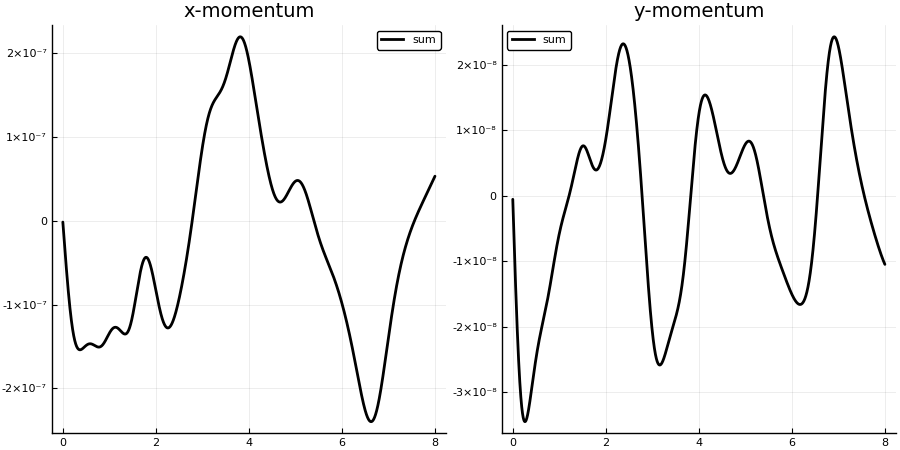

In [98]:
p1 = plot(t,xmsum,title="x-momentum",label="sum",linewidth=2,color="black")
p2 = plot(t,ymsum,title="y-momentum",label="sum",linewidth=2,color="black")

plot(p1,p2,size=(900,450))

## Energy Conservation 

In [99]:
n = length(solns)-1
t = [solns[i].t for i=3:n+1];

# y_n+1 = y_n + RK(y'_n)
ekin = [dict["ekin"][i]-dict["ekin"][i-1] for i=2:n]
espr = [dict["espr"][i]-dict["espr"][i-1] for i=2:n]
egra = [dict["egra"][i]-dict["egra"][i-1] for i=2:n]
esum = ekin + espr + egra;

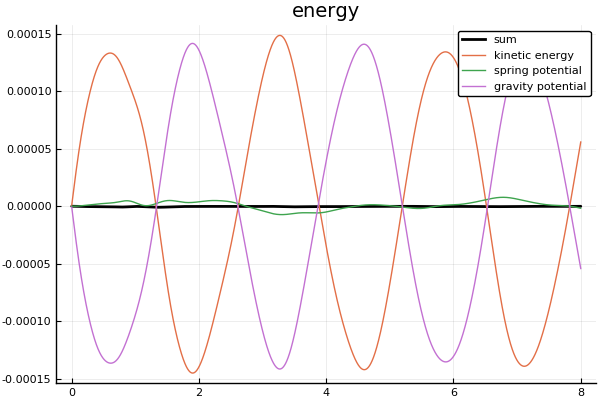

In [100]:
plot(t,esum,title="energy",label="sum",linewidth=2,color="black")
plot!(t,ekin,label="kinetic energy")
plot!(t,espr,label="spring potential")
plot!(t,egra,label="gravity potential")

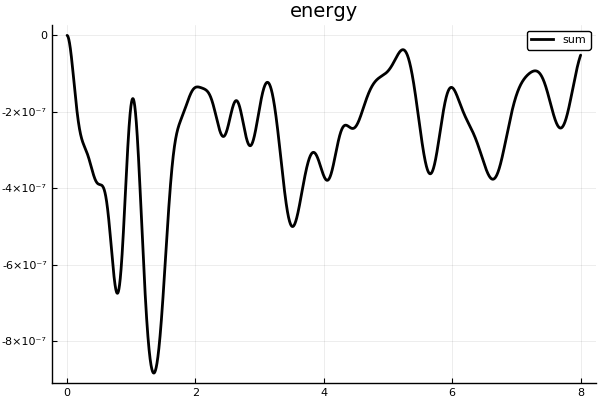

In [101]:
plot(t,esum,title="energy",label="sum",linewidth=2,color="black")

## Varying timestep and compare error in energy conservation

In [36]:
# dt = 1.6e-2
t_1 = t
esum_1 = esum;

In [57]:
# dt = 8e-3
t_2 = t
esum_2 = esum;

In [72]:
# dt = 4e-3
t_3 = t
esum_3 = esum;

In [87]:
# dt = 2e-3
t_4 = t
esum_4 = esum;

In [102]:
# dt = 1e-3
t_5 = t
esum_5 = esum;

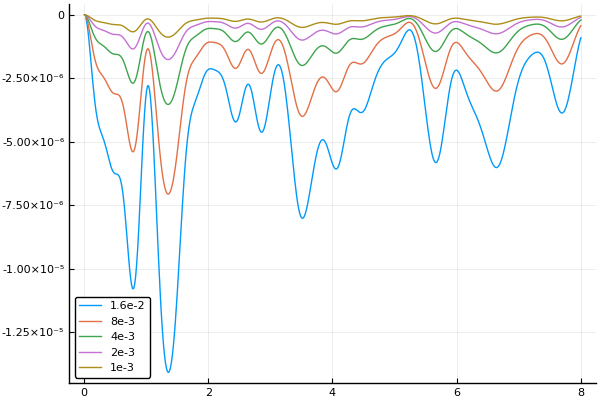

In [103]:
plot(t_1,esum_1,label="1.6e-2")
plot!(t_2,esum_2,label="8e-3")
plot!(t_3,esum_3,label="4e-3")
plot!(t_4,esum_4,label="2e-3")
plot!(t_5,esum_5,label="1e-3")

In [104]:
# choose t=4 to compare the errors
println(esum_1[250]/esum_2[500])
println(esum_2[500]/esum_3[1000])
println(esum_3[1000]/esum_4[2000])
println(esum_4[2000]/esum_5[4000])

2.013829650328958
2.0056592527137123
2.002502558322727
2.001168002144375
